# Credit Risk & Loan Performance: 

#### Author: Satveer Kaur
#### Date: 2025-10-28
#### Notebook Purpose:
The primary goal of this notebook is to transition from **data preparation** to **insight generation**. Using the clean, feature-engineered dataset (`final_loan_data.csv`), the analysis will visually explore the data to achieve the following:
1. **Validate Feature Predictive Power:** Graphically confirm the risk trends established in Notebook 2 (e.g., higher default rate for lower FICO scores).
2. **Identify Key Risk Drivers:** Determine which engineered segments (FICO, DTI, Income) are the most impactful predictors of loan default.
3. **Inform Model Design:** Discover crucial relationships and interactions between variables that must be accounted for in the predictive modeling phase.

This notebook serves as the **analytical foundation** for the project, translating raw data into clear, actionable business insights and risk narratives.

#### 1. Load Sample Datasets
**Purpose**: Load the final clean, feature-engineered datasets `final_loan_data.csv`

In [120]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load sample datasets
final_loan_data = pd.read_csv('../data/sample_data/final_loan_data.csv', low_memory=False, parse_dates=['issue_date'])

In [121]:
sns.set_palette("Set2")

#### 2. Initial Data Inspection and Cleaning 
**Purpose**: To confirm the data loaded correctly, verify data types (especially for the new categorical features), and get a high-level view of the dataset's structure.

##### 2.1 Initial Observation
**Purpose**: Display the first few rows and summary statistics to immediately identify any data type issues or missing values that require cleaning before EDA.

In [122]:
final_loan_data.head()

,is_default,amount_requested,funded_amount,interest_rate,installment,term_num,fico_bin,dti_quintile,income_brackets,purpose_grouped,fico_score,annual_income,debt_to_income_ratio,grade,sub_grade,total_bc_limit,total_il_high_credit_limit,issue_date
0,0,25000.0,25000.0,15.95,878.31,36,Good (670-739),Q2,$50k - $100k,debt_consolidation,702.0,74872.0,13.66,D,D4,NaN,NaN,2010-09-01
1,1,19200.0,19200.0,21.97,529.96,60,Subprime/Poor (<670),Q4,$50k - $100k,debt_consolidation,662.0,75000.0,23.18,E,E4,7400.0,83426.0,2016-03-01
2,0,35000.0,35000.0,14.49,1204.57,36,Good (670-739),Q2,$100k - $150k,Other,672.0,110000.0,14.85,C,C4,23600.0,37691.0,2016-09-01
3,1,24500.0,24500.0,11.44,538.09,60,Good (670-739),Q2,$50k - $100k,credit_card,707.0,78000.0,13.03,B,B4,27200.0,14738.0,2015-01-01
4,1,15250.0,15250.0,15.10,529.40,36,Good (670-739),Q4,$50k - $100k,home_improvement,672.0,50000.0,21.51,C,C2,4000.0,45499.0,2013-12-01


In [123]:
final_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134611 entries, 0 to 134610
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   is_default                  134611 non-null  int64         
 1   amount_requested            134611 non-null  float64       
 2   funded_amount               134611 non-null  float64       
 3   interest_rate               134611 non-null  float64       
 4   installment                 134611 non-null  float64       
 5   term_num                    134611 non-null  int64         
 6   fico_bin                    134611 non-null  object        
 7   dti_quintile                134576 non-null  object        
 8   income_brackets             134611 non-null  object        
 9   purpose_grouped             134611 non-null  object        
 10  fico_score                  134611 non-null  float64       
 11  annual_income               134611 non-

In [124]:
final_loan_data.shape

(134611, 18)

##### 2.2 Handling Missing Data
**Observation**: The financial metrics `total_bc_limit` and `total_il_high_credit_limit` contain NaN values. This missingness must be quantified and handled before they can be used in modeling.
**Purpose:** Impute missing values for credit limit features using the median— a robust strategy for often-skewed financial data and confirm the successful imputation.

In [125]:
missing_pct = final_loan_data[['total_bc_limit','total_il_high_credit_limit']].isna().mean() * 100
print(missing_pct)

total_bc_limit                3.599260
total_il_high_credit_limit    5.125138
dtype: float64


In [126]:
# fill total_bc_limit with median
total_bc_limit_median = final_loan_data['total_bc_limit'].median()
final_loan_data['total_bc_limit']=final_loan_data['total_bc_limit'].fillna(total_bc_limit_median)

# fill total_il_high_credit_limit with median
total_il_high_credit_median = final_loan_data['total_il_high_credit_limit'].median()
final_loan_data['total_il_high_credit_limit'] = final_loan_data['total_il_high_credit_limit'].fillna(total_il_high_credit_median)

#### 3. Risk Trend Analysis
**Purpose**: The most critical part of a credit risk project is visualizing the relationship between your engineered risk segments and the target variable, `is_default`. This section will visually confirm that your Feature Engineering in Notebook 2 was effective.

##### 3.1 FICO Risk Trend
**Purpose:** Visualize the **Observed Default Rate (ODR)** across the **FICO bins**. The expected result is a strong, negative correlation: as FICO score increases (moving from Subprime to Excellent), the ODR must decrease.

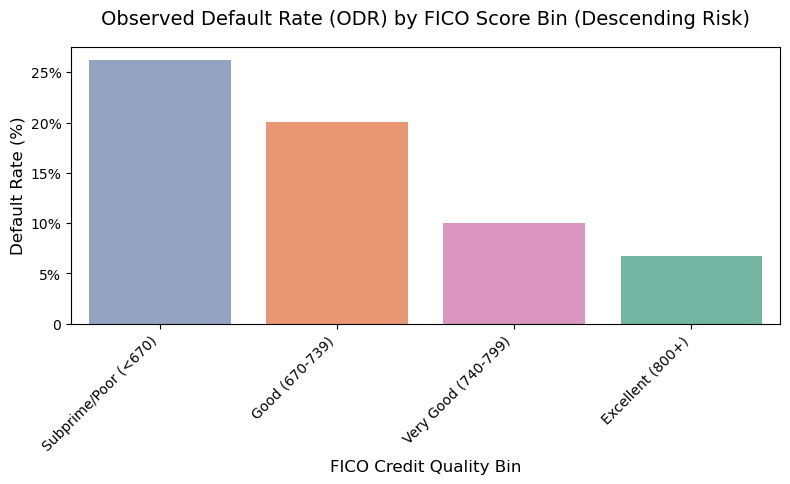

In [127]:
fico_odr = final_loan_data.groupby('fico_bin')['is_default'].mean()

# correct risk order from lowest score to highest score
fico_order = [
    'Subprime/Poor (<670)',
    'Good (670-739)',
    'Very Good (740-799)',
    'Excellent (800+)'
]

fico_odr_df = fico_odr.reset_index(name='default_rate')

# visualize FICO risk
plt.figure(figsize=(8, 5))
sns.barplot(
    data = fico_odr_df, 
    y='default_rate', 
    x='fico_bin',
    hue='fico_bin',
    palette='Set2',
    order=fico_order
)
# Set title and labels
plt.title('Observed Default Rate (ODR) by FICO Score Bin (Descending Risk)', fontsize=14, y=1.05)
plt.xlabel('FICO Credit Quality Bin', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:.0%}' if x else '0'))
plt.tight_layout()
plt.show()

##### 3.2 DTI Risk Trend
**Purpose:** Visualize the **Observed Default Rate (ODR)** across the DTI Quintiles. The expected result is a positive correlation: as DTI Quintile increases (moving to higher DTI ratios), the ODR must increase.

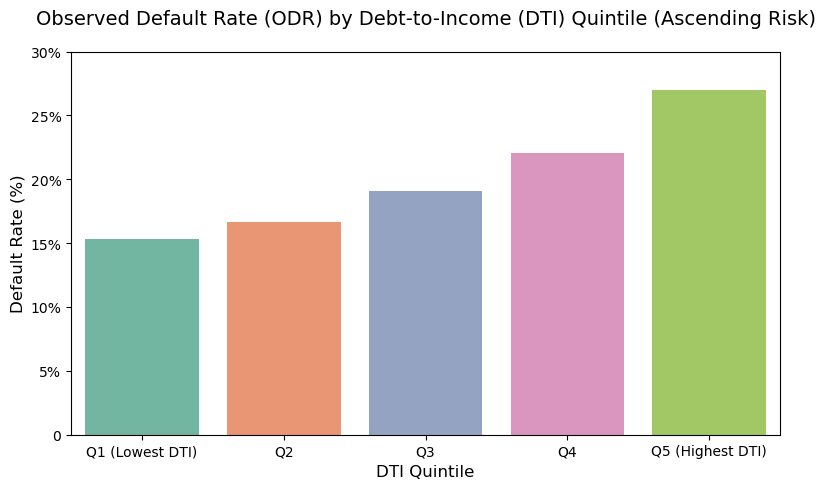

In [128]:
plt.figure(figsize=(8,5))
dti_odr = final_loan_data.groupby('dti_quintile')['is_default'].mean()
dti_odr_df = dti_odr.reset_index(name='default_rate')
sns.barplot(
    data=dti_odr_df,
    x='dti_quintile',
    y='default_rate',
    palette='Set2',
    hue='dti_quintile'
)

# title and labels
plt.title('Observed Default Rate (ODR) by Debt-to-Income (DTI) Quintile (Ascending Risk)', fontsize=14, y=1.05)
plt.ylim(0,0.30)
plt.xlabel('DTI Quintile', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:.0%}' if x else '0'))
plt.tight_layout()
plt.show()

##### 3.3 Income Risk Trend
**Purpose:** Visualize the **Observed Default Rate (ODR)** across the Income Brackets. We expect a negative correlation: as income increases, the ODR should decrease.

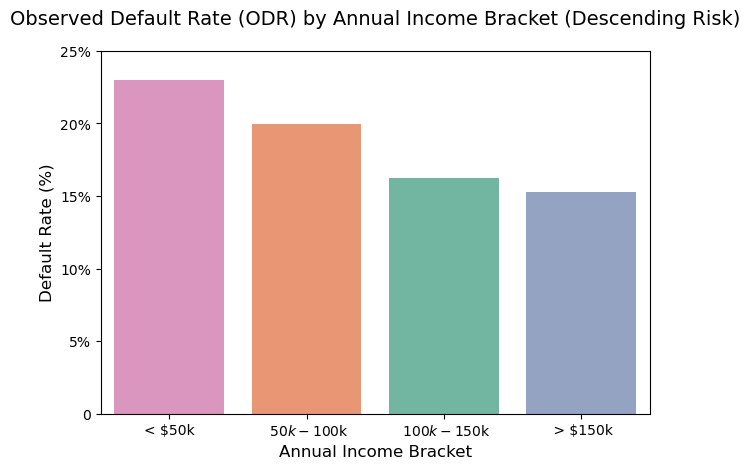

In [129]:
income_odr = final_loan_data.groupby('income_brackets')['is_default'].mean()
income_odr_df = income_odr.reset_index(name='default_rate')
income_order = ['< $50k',' $50k - $100k',' $100k - $150k', ' > $150k']
sns.barplot(
    data=income_odr_df,
    x='income_brackets',
    y='default_rate',
    hue='income_brackets',
    palette='Set2',
    order=income_order
)
# title and labels
plt.title('Observed Default Rate (ODR) by Annual Income Bracket (Descending Risk)', fontsize=14, y=1.05)
plt.ylim(0,0.25)
plt.xlabel('Annual Income Bracket', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:.0%}' if x else '0'))
plt.tight_layout()
plt.show()

#### 4. Summary of Key Risk Findings

Based on the visualization of Observed Default Rates (ODR) across the core engineered features, we confirmed several critical risk trends that validate the segmentation strategy:

1. **FICO Score (Credit Quality):** Confirmed the expected inverse relationship. The **Observed Default Rate (ODR) decreases significantly** as the FICO Score Bin increases (e.g., risk is substantially lower in the Excellent bin than the Subprime/Poor bin). This feature is a powerful risk differentiator.

2. **DTI Quintile (Leverage):** Confirmed the expected positive correlation. The ODR increases monotonically across the quintiles, proving that borrowers with a higher Debt-to-Income (DTI) ratio have a proportionally higher probability of default.

3. **Annual Income: (Capacity)** Confirmed the expected inverse relationship. The ODR decreases as the Annual Income Bracket increases, indicating that higher financial capacity acts as a protective factor against default.

#### 5. Next Steps: Final Data Preparation for Reporting

##### 5.1 Feature Type Conversion to `category`

In [130]:
cat_features = [
    'purpose_grouped', 
    'fico_bin', 
    'dti_quintile', 
    'income_brackets'
]
for col in cat_features:
    final_loan_data[col] = final_loan_data[col].astype('category')

print(final_loan_data[cat_features].dtypes)

purpose_grouped    category
fico_bin           category
dti_quintile       category
income_brackets    category
dtype: object


##### 5.2 Final Save 

In [131]:
output_path = '../data/clean_data/clean_data_for_reporting.csv'
final_loan_data.to_csv(output_path, index=False)

#### 6. Summary and Next Steps

##### Summary

This notebook successfully executed the core Exploratory Data Analysis (EDA) and final data preparation:
1. **Data Cleaning:** Handled missing values in credit limit features (`total_bc_limit`, `total_il_high_credit_limit`) using median imputation.
2. **Risk Validation:** Created and visualized three key risk segmentation charts (**FICO bins, DTI quintiles, Income brackets**), confirming the expected risk hierarchy for all engineered features.
3. **Data Preparation:** Finalized the dataset by converting key categorical columns to the category data type for optimization and consistent reporting.
4. **Final Save:** Saved the final, cleaned dataset as a checkpoint for the next phase.

##### Next Steps
The data is now clean, structured, and validated. The next phase of this project will focus on quantifying these visual insights for professional reporting.

**Notebook 4: Risk Reporting and Segmentation Tables** will involve:
1. Loading the `clean_data_for_reporting.csv` file.
2. Creating structured tables (segmentation matrices) to quantify the **Loan Count, Default Count, and Observed Default Rate (ODR)** for all key risk variables (FICO, DTI, Income).
3. Exporting these final reports, which serve as the primary deliverable for management and audit.